# Assignment 3: Question Answering

Welcome to the third assignment of course 4. In this assignment you will explore question answering. You will implement the "Text to Text Transfer from Transformers" (better known as T5). Since you implemented transformers from scratch last week you will now be able to use them. 

## Table of Contents

- [Overview](#0-1)
- [Importing the Packages](#0-2)
- [1 - Prepare the data for pretraining T5](#1)
    - [1.1 - Pre-Training Objective](#1-1)
    - [1.2 - C4 Dataset](#1-2)
    - [1.3 - Process C4](#1-3)
    - [1.4 - Decode to Natural Language](#1-4)
    - [1.5 - Tokenizing and Masking](#1-5)
        - [Exercise 1 - tokenize_and_mask](#ex-1)
    - [1.6 - Creating the Pairs](#1-6)
- [2 - Pretrain a T5 model using C4](#2)
    - [2.1 - Instantiate a new transformer model](#2-1)
    - [2.2 - C4 pretraining](#2-2)
- [3 - Fine tune the T5 model for Question Answering](#3)
    - [3.1 - Creating a list of paired question and answers](#3-1)
        - [Exercise 2 - Parse the SQuaD 2.0 dataset](#ex-2)
    - [3.2 - Fine tune the T5 model](#3-2)    
    - [3.3 - Implement your Question Answering model](#3-3)
        - [Exercise 3 - Implement the question answering function](#ex-3)    

<a name='0-1'></a>
## Overview

This assignment will be different from the two previous ones. Due to memory constraints of this environment and for the sake of time, your model will be trained with small datasets, so you won't get models that you could use in production but you will gain the necessary knowledge about how the Generative Language models are trained and used. Also you won't spend too much time with the architecture of the models but you will instead take a model that is pre-trained on a larger dataset and fine tune it to get better results.

After completing this labs you will:
* Understand how the C4 dataset is structured.
* Pretrain a transformer model using a Masked Language Model.
* Understand how the "Text to Text Transfer from Transformers" or T5 model works. 
* Fine tune the T5 model for Question answering

Before getting started take some time to read the following tips:
#### TIPS FOR SUCCESSFUL GRADING OF YOUR ASSIGNMENT:
- All cells are frozen except for the ones where you need to submit your solutions.
- You can add new cells to experiment but these will be omitted by the grader, so don't rely on newly created cells to host your solution code, use the provided places for this.
- You can add the comment # grade-up-to-here in any graded cell to signal the grader that it must only evaluate up to that point. This is helpful if you want to check if you are on the right track even if you are not done with the whole assignment. Be sure to remember to delete the comment afterwards!
- To submit your notebook, save it and then click on the blue submit button at the beginning of the page.

<a name='0-2'></a>
## Importing the Packages

Let's start by importing all the required libraries. 

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import traceback
import time
import json
from termcolor import colored
import string
import textwrap
import itertools
import numpy as np
import tensorflow_text as tf_text
import tensorflow as tf

import transformer_utils 
import utils

# Will come in handy later
wrapper = textwrap.TextWrapper(width=70)

# Set random seed
np.random.seed(42)

In [2]:
import w3_unittest

<a name='1'></a>
## 1 -  Prepare the data for pretraining T5 

<a name='1-1'></a>
### 1.1 - Pre-Training Objective

In the initial phase of training a T5 model for a Question Answering task, the pre-training process involves leveraging a masked language model (MLM) on a very large dataset, such as the C4 dataset. The objective is to allow the model to learn contextualized representations of words and phrases, fostering a deeper understanding of language semantics. To initiate pre-training, it is essential to employ the Transformer architecture, which forms the backbone of T5. The Transformer's self-attention mechanism enables the model to weigh different parts of the input sequence dynamically, capturing long-range dependencies effectively.

Before delving into pre-training, thorough data preprocessing is crucial. The C4 dataset, a diverse and extensive collection of web pages, provides a rich source for language understanding tasks. The dataset needs to be tokenized into smaller units, such as subwords or words, to facilitate model input. Additionally, the text is often segmented into fixed-length sequences or batches, optimizing computational efficiency during training.

For the masked language modeling objective, a percentage of the tokenized input is randomly masked, and the model is trained to predict the original content of these masked tokens. This process encourages the T5 model to grasp contextual relationships between words and phrases, enhancing its ability to generate coherent and contextually appropriate responses during downstream tasks like question answering.

In summary, the pre-training of the T5 model involves utilizing the Transformer architecture on a sizable dataset like C4, coupled with meticulous data preprocessing to convert raw text into a format suitable for training. The incorporation of a masked language modeling objective ensures that the model learns robust contextual representations, laying a solid foundation for subsequent fine-tuning on specific tasks such as question answering.

**Note:** The word "mask" will be used throughout this assignment in context of hiding/removing word(s)

You will be implementing the Masked language model (MLM) as shown in the following image. 

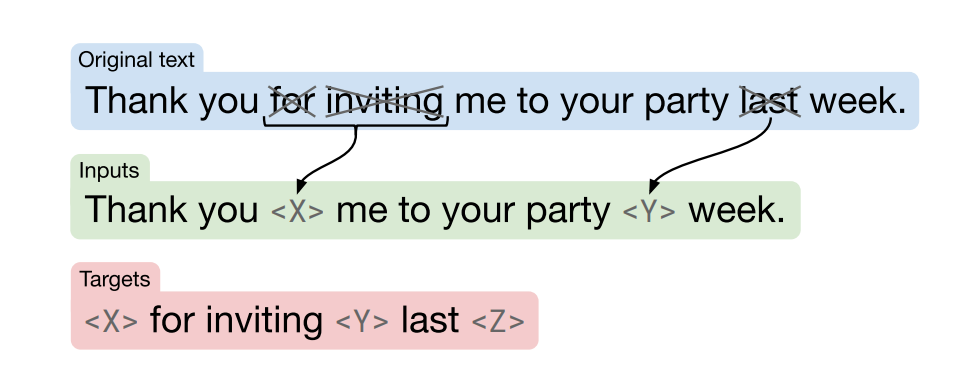

Assume you have the following text: <span style = "color:blue"> **Thank you <span style = "color:red">for inviting </span> me to your party <span style = "color:red">last</span>  week** </span> 


Now as input you will mask the words in red in the text: 

<span style = "color:blue"> **Input:**</span> Thank you  **X** me to your party **Y** week.

<span style = "color:blue">**Output:**</span> The model should predict the words(s) for **X** and **Y**. 

**[EOS]** will be used to mark the end of the target sequence.

<a name='1-2'></a>
### 1.2 - C4 Dataset

The [C4 dataset](https://www.tensorflow.org/datasets/catalog/c4), also known as the Common Crawl C4 (Common Crawl Corpus C4), is a large-scale dataset of web pages collected by the [Common Crawl organization](https://commoncrawl.org/). It is commonly used for various natural language processing tasks and machine learning research. Each sample in the C4 dataset follows a consistent format, making it suitable for pretraining models like BERT. Here's a short explanation and description of the C4 dataset:

- Format: Each sample in the C4 dataset is represented as a JSON object, containing several key-value pairs.

- Content: The 'text' field in each sample contains the actual text content extracted from web pages. This text often includes a wide range of topics and writing styles, making it diverse and suitable for training language models.

- Metadata: The dataset includes metadata such as 'content-length,' 'content-type,' 'timestamp,' and 'url,' providing additional information about each web page. 'Content-length' specifies the length of the content, 'content-type' describes the type of content (e.g., 'text/plain'), 'timestamp' indicates when the web page was crawled, and 'url' provides the source URL of the web page.

- Applications: The C4 dataset is commonly used for training and fine-tuning large-scale language models, such as BERT. It serves as a valuable resource for tasks like text classification, named entity recognition, question answering, and more.

- Size: The C4 dataset is containing more than 800 GiB of text data, making it suitable for training models with billions of parameters.

Run the cell below to see how the C4 dataset looks like. 

In [3]:
# Load example jsons
with open('data/c4-en-10k.jsonl', 'r') as file:
    example_jsons = [json.loads(line.strip()) for line in file]

# Printing the examples to see how the data looks like
for i in range(5):
    print(f'example number {i+1}: \n\n{example_jsons[i]} \n')

example number 1: 

{'text': 'Beginners BBQ Class Taking Place in Missoula!\nDo you want to get better at making delicious BBQ? You will have the opportunity, put this on your calendar now. Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. He will be teaching a beginner level class for everyone who wants to get better with their culinary skills.\nHe will teach you everything you need to know to compete in a KCBS BBQ competition, including techniques, recipes, timelines, meat selection and trimming, plus smoker and fire information.\nThe cost to be in the class is $35 per person, and for spectators it is free. Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared.'} 

example number 2: 

{'text': 'Discussion in \'Mac OS X Lion (10.7)\' started by axboi87, Jan 20, 2012.\nI\'ve got a 500gb internal drive and a 240gb SSD.\nWhen trying to restore using disk utility i\'m given the err

<a name='1-3'></a>
### 1.3 - Process C4

For the purpose of pretaining the T5 model, you will only use the `content` of each entry. In the following code, you filter only the field `text` from all the entries in the dataset. This is the data that you will use to create the `inputs` and `targets` of your language model.

In [4]:
# Grab text field from dictionary
natural_language_texts = [example_json['text'] for example_json in example_jsons]

# Print the first text example
print(natural_language_texts[0])

Beginners BBQ Class Taking Place in Missoula!
Do you want to get better at making delicious BBQ? You will have the opportunity, put this on your calendar now. Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. He will be teaching a beginner level class for everyone who wants to get better with their culinary skills.
He will teach you everything you need to know to compete in a KCBS BBQ competition, including techniques, recipes, timelines, meat selection and trimming, plus smoker and fire information.
The cost to be in the class is $35 per person, and for spectators it is free. Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared.


<a name='1-4'></a>
### 1.4 - Decode to Natural Language

The [SentencePieceTokenizer](https://www.tensorflow.org/text/api_docs/python/text/SentencepieceTokenizer), used in the code snippet, tokenizes text into subword units, enhancing handling of complex word structures, out-of-vocabulary words, and multilingual support. It simplifies preprocessing, ensures consistent tokenization, and seamlessly integrates with machine learning frameworks.

In this task, a SentencePiece model is loaded from a file, which is used to tokenize text into subwords represented by integer IDs.

In [5]:
# Special tokens
# PAD, EOS = 0, 1

with open("./models/sentencepiece.model", "rb") as f:
    pre_trained_tokenizer = f.read()
    
tokenizer = tf_text.SentencepieceTokenizer(pre_trained_tokenizer, out_type=tf.int32)

In this tokenizer the string `</s>` is used as `EOS` token. By default, the tokenizer does not add the `EOS` to the end of each sentence, so you need to add it manually when required. Let's verify what id correspond to this token:

In [6]:
eos = tokenizer.string_to_id("</s>").numpy()

print("EOS: " + str(eos))

EOS: 1


This code shows the process of tokenizing individual words from a given text, in this case, the first entry of the dataset.

In [7]:
# printing the encoding of each word to see how subwords are tokenized
tokenized_text = [(list(tokenizer.tokenize(word).numpy()), word) for word in natural_language_texts[2].split()]

print("Word\t\t-->\tTokenization\n")
for element in tokenized_text:
    print(f"{element[1]}\t-->\t{element[0]}")

Word		-->	Tokenization

Foil	-->	[4452, 173]
plaid	-->	[30772]
lycra	-->	[3, 120, 2935]
and	-->	[11]
spandex	-->	[8438, 26, 994]
shortall	-->	[710, 1748]
with	-->	[28]
metallic	-->	[18813]
slinky	-->	[3, 7, 4907, 63]
insets.	-->	[16, 2244, 7, 5]
Attached	-->	[28416, 15, 26]
metallic	-->	[18813]
elastic	-->	[15855]
belt	-->	[6782]
with	-->	[28]
O-ring.	-->	[411, 18, 1007, 5]
Headband	-->	[3642, 3348]
included.	-->	[1285, 5]
Great	-->	[1651]
hip	-->	[5436]
hop	-->	[13652]
or	-->	[42]
jazz	-->	[9948]
dance	-->	[2595]
costume.	-->	[11594, 5]
Made	-->	[6465]
in	-->	[16]
the	-->	[8]
USA.	-->	[2312, 5]


And as usual, the library provides a function to turn numeric tokens into human readable text. Look how it works. 

In [8]:
# We can see that detokenize successfully undoes the tokenization
print(f"tokenized: {tokenizer.tokenize('Beginners')}\ndetokenized: {tokenizer.detokenize(tokenizer.tokenize('Beginners'))}")

tokenized: [12847   277]
detokenized: b'Beginners'


As you can see above, you were able to take a piece of string and tokenize it. 

Now you will create `input` and `target` pairs that will allow you to train your model. T5 uses the ids at the end of the vocab file as sentinels. For example, it will replace: 
   - `vocab_size - 1` by `<Z>`
   - `vocab_size - 2` by `<Y>`
   - and so forth. 
   
It assigns every word a `chr`.

The `pretty_decode` function below, which you will use in a bit, helps in handling the type when decoding. Take a look and try to understand what the function is doing.


Notice that:
```python
string.ascii_letters = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
```

**NOTE:** Targets may have more than the 52 sentinels we replace, but this is just to give you an idea of things.

In [9]:
def get_sentinels(tokenizer, display=False):
    sentinels = {}
    vocab_size = tokenizer.vocab_size(name=None)
    for i, char in enumerate(reversed(string.ascii_letters), 1):
        decoded_text = tokenizer.detokenize([vocab_size - i]).numpy().decode("utf-8")
        
        # Sentinels, ex: <Z> - <a>
        sentinels[decoded_text] = f'<{char}>'    
    
        if display:
            print(f'The sentinel is <{char}> and the decoded token is:', decoded_text)

    return sentinels

def pretty_decode(encoded_str_list, sentinels, tokenizer):
    # If already a string, just do the replacements.
    if tf.is_tensor(encoded_str_list) and encoded_str_list.dtype == tf.string:
        for token, char in sentinels.items():
            encoded_str_list = tf.strings.regex_replace(encoded_str_list, token, char)
        return encoded_str_list
  
    # We need to decode and then prettyfy it.
    return pretty_decode(tokenizer.detokenize(encoded_str_list), sentinels, tokenizer)

In [10]:
sentinels = get_sentinels(tokenizer, display=True)

The sentinel is <Z> and the decoded token is: Internațional
The sentinel is <Y> and the decoded token is: erwachsene
The sentinel is <X> and the decoded token is: Cushion
The sentinel is <W> and the decoded token is: imunitar
The sentinel is <V> and the decoded token is: Intellectual
The sentinel is <U> and the decoded token is: traditi
The sentinel is <T> and the decoded token is: disguise
The sentinel is <S> and the decoded token is: exerce
The sentinel is <R> and the decoded token is: nourishe
The sentinel is <Q> and the decoded token is: predominant
The sentinel is <P> and the decoded token is: amitié
The sentinel is <O> and the decoded token is: erkennt
The sentinel is <N> and the decoded token is: dimension
The sentinel is <M> and the decoded token is: inférieur
The sentinel is <L> and the decoded token is: refugi
The sentinel is <K> and the decoded token is: cheddar
The sentinel is <J> and the decoded token is: unterlieg
The sentinel is <I> and the decoded token is: garanteaz
Th

Now, let's use the `pretty_decode` function in the following sentence. Note that all the words listed as sentinels, will be replaced by the function with the corresponding sentinel. It could be a drawback of this method, but don't worry about it now.

In [11]:
pretty_decode(tf.constant("I want to dress up as an Intellectual this halloween."), sentinels, tokenizer)

<tf.Tensor: shape=(), dtype=string, numpy=b'I want to dress up as an <V> this <b>.'>

The functions above make your `inputs` and `targets` more readable. For example, you might see something like this once you implement the masking function below. 

- <span style="color:red"> Input sentence: </span> Younes and Lukasz were working together in the lab yesterday after lunch. 
- <span style="color:red">Input: </span> Younes and Lukasz  **Z** together in the **Y** yesterday after lunch.
- <span style="color:red">Target: </span> **Z** were working **Y** lab.


<a name='1-5'></a>
### 1.5 - Tokenizing and Masking

In this task, you will implement the `tokenize_and_mask` function, which tokenizes and masks input words based on a given probability. The probability is controlled by the `noise` parameter, typically set to mask around `15%` of the words in the input text. The function will generate two lists of tokenized sequences following the algorithm outlined below:

<a name='ex-1'></a>
### Exercise 1 - tokenize_and_mask

- Start with two empty lists: `inps` and `targs`
- Tokenize the input text using the given tokenizer.
- For each `token` in the tokenized sequence:
  - Generate a random number(simulating a weighted coin toss)
  - If the random value is greater than the given threshold(noise):
    - Add the current token to the `inps` list
  - Else:
    - If a new sentinel must be included(read note **):
      - Compute the next sentinel ID using a progression.
      - Add a sentinel into the `inps` and `targs` to mark the position of the masked element.
    - Add the current token to the `targs` list.

** There's a special case to consider. If two consecutive tokens get masked during the process, you don't need to add a new sentinel to the sequences. To account for this, use the `prev_no_mask` flag, which starts as `True` but is turned to `False` each time you mask a new element. The code that adds sentinels will only be executed if, before masking the token, the flag was in the `True` state.


In [12]:
# GRADED FUNCTION: tokenize_and_mask
def tokenize_and_mask(text, 
                      noise=0.15, 
                      randomizer=np.random.uniform, 
                      tokenizer=None):
    """Tokenizes and masks a given input.

    Args:
        text (str or bytes): Text input.
        noise (float, optional): Probability of masking a token. Defaults to 0.15.
        randomizer (function, optional): Function that generates random values. Defaults to np.random.uniform.
        tokenizer (function, optional): Tokenizer function. Defaults to tokenize.

    Returns:
        inps, targs: Lists of integers associated to inputs and targets.
    """
    
    # Current sentinel number (starts at 0)
    cur_sentinel_num = 0
    
    # Inputs and targets
    inps, targs = [], []

    # Vocab_size
    vocab_size = int(tokenizer.vocab_size())
    
    # EOS token id 
    # Must be at the end of each target!
    eos = tokenizer.string_to_id("</s>").numpy()
    
    ### START CODE HERE ###
    
    # prev_no_mask is True if the previous token was NOT masked, False otherwise
    # set prev_no_mask to True
    prev_no_mask = True
    
    # Loop over the tokenized text
    for token in tokenizer.tokenize(text).numpy():
        
        # Generate a random value between 0 and 1
        rnd_val = randomizer() 
        
        # Check if the noise is greater than a random value (weighted coin flip)
        if noise > rnd_val:
            
            # Check if previous token was NOT masked
            if prev_no_mask:
                
                # Current sentinel increases by 1
                cur_sentinel_num += 1
                
                # Compute end_id by subtracting current sentinel value out of the total vocabulary size
                end_id = vocab_size - cur_sentinel_num
                
                # Append end_id at the end of the targets
                targs.append(end_id)
                
                # Append end_id at the end of the inputs
                inps.append(end_id)
                
            # Append token at the end of the targets
            targs.append(token)
            
            # set prev_no_mask accordingly
            prev_no_mask = False

        else:
            
            # Append token at the end of the inputs
            inps.append(token)
            
            # Set prev_no_mask accordingly
            prev_no_mask = False
    
    
    # Add EOS token to the end of the targets
    targs.append(eos)
    
    ### END CODE HERE ###
    
    return inps, targs

In [13]:
# Some logic to mock a np.random value generator
# Needs to be in the same cell for it to always generate same output
def testing_rnd():
    def dummy_generator():
        vals = np.linspace(0, 1, 10)
        cyclic_vals = itertools.cycle(vals)
        for _ in range(100):
            yield next(cyclic_vals)

    dumr = itertools.cycle(dummy_generator())

    def dummy_randomizer():
        return next(dumr)
    
    return dummy_randomizer

input_str = 'Beginners BBQ Class Taking Place in Missoula!\nDo you want to get better at making delicious BBQ? You will have the opportunity, put this on your calendar now. Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers.'

inps, targs = tokenize_and_mask(input_str, randomizer=testing_rnd(), tokenizer=tokenizer)
print(f"tokenized inputs - shape={len(inps)}:\n\n{inps}\n\ntargets - shape={len(targs)}:\n\n{targs}")

tokenized inputs - shape=48:

[31999, 15068, 4501, 3, 12297, 3399, 16, 5964, 7115, 531, 25, 241, 12, 129, 394, 44, 492, 58, 148, 56, 43, 8, 1004, 6, 474, 39, 4793, 230, 5, 2721, 6, 1600, 1630, 1150, 4501, 15068, 16127, 6, 9137, 2659, 5595, 782, 3624, 14627, 15, 12612, 277, 5]

targets - shape=14:

[31999, 12847, 277, 9, 55, 3326, 15068, 48, 30, 727, 1715, 45, 301, 1]


#### **Expected Output:**
```
tokenized inputs - shape=53:

[31999 15068  4501     3 12297  3399    16  5964  7115 31998   531    25
   241    12   129   394    44   492 31997    58   148    56    43     8
  1004     6   474 31996    39  4793   230     5  2721     6  1600  1630
 31995  1150  4501 15068 16127     6  9137  2659  5595 31994   782  3624
 14627    15 12612   277     5]

targets - shape=19:

[31999 12847   277 31998     9    55 31997  3326 15068 31996    48    30
 31995   727  1715 31994    45   301     1]
```

In [14]:
# Test your implementation!
w3_unittest.test_tokenize_and_mask(tokenize_and_mask)

 All tests passed


You will now use the inputs and the targets from the `tokenize_and_mask` function you implemented above. Take a look at the decoded version of your masked sentence using your `inps` and `targs` from the sentence above. 

In [15]:
print('Inputs: \n\n', pretty_decode(inps, sentinels, tokenizer).numpy())
print('\nTargets: \n\n', pretty_decode(targs, sentinels, tokenizer).numpy())

Inputs: 

 b'<Z> BBQ Class Taking Place in Missoul Do you want to get better at making? You will have the opportunity, put your calendar now. Thursday, September 22 World Class BBQ Champion, Tony Balayonestar Smoke Rangers.'

Targets: 

 b'<Z> Beginnersa! delicious BBQ this onnd join from L'


<a name='1-6'></a>
### 1.6 - Creating the Pairs

You will now create pairs using your dataset. You will iterate over your data and create (inp, targ) pairs using the functions that we have given you. 

In [16]:
# Apply tokenize_and_mask
inputs_targets_pairs = [tokenize_and_mask(text.encode('utf-8', errors='ignore').decode('utf-8'), tokenizer=tokenizer) 
                        for text in natural_language_texts[0:2000]]

In [17]:
def display_input_target_pairs(inputs_targets_pairs, sentinels, wrapper=textwrap.TextWrapper(width=70), tokenizer=tokenizer):
    for i, inp_tgt_pair in enumerate(inputs_targets_pairs, 1):
        inps, tgts = inp_tgt_pair
        inps = str(pretty_decode(inps, sentinels, tokenizer).numpy(), encoding='utf-8')
        tgts = str(pretty_decode(tgts, sentinels, tokenizer).numpy(), encoding='utf-8')
        print(f'[{i}]\n\n'
              f'inputs:\n{wrapper.fill(text=inps)}\n\n'
              f'targets:\n{wrapper.fill(text=tgts)}\n\n\n')

# Print the first 5 samples
display_input_target_pairs(inputs_targets_pairs[0:5], sentinels, wrapper, tokenizer)

[1]

inputs:
Beginners BBQ Class Taking in Missoul! Do you want to get better at
making delicious? You will have the opportunity, this on calendar now.
Thursday September 22 join Class BBQ Champion, Tony Balay from
Lonestar Smokeers He will be teaching a beginner class everyone who
wants get better with their skills He will teach everything you need
to know to in a KCBS BBQ techniques, recipes, timelines, meat and
trimming, plus smoker and fire information. The cost to be the class
is $35 person, and spectators it is free. Included in the cost will
either  t- or apron and you will be tasting samples each meat that
prepared.

targets:
Placea BBQ put your,nd World Rang. level for to culinary. you compete
competition, including selection in per for beashirt of is



[2]

inputs:
<Z> in 'Mac OS X (107)' started by axbi87, Jan 20, 2012. I've gota
500g drive a 240gb SSD. When trying to restore using utility i'm given
the error "Not enough space on disk____ to restore But I shouldn't
have to 

<a name='2'></a>
## 2 - Pretrain a T5 model using C4

Now you are going to use the Transformer's architecture that you coded in the previous assignment to summarize text, but this time to answer questions. Instead of training the question answering model from scratch, you will first "pre-train" the model using the C4 data set you just processed. This will help the model to learn the general structure of language from a large dataset. This is much easier to do, as you don't need to label any data, but just use the masking, which is done automatically. You will then use the data from the SQuAD set to teach the model to answer questions given a context. To start let's review the Transformer's architecture. 

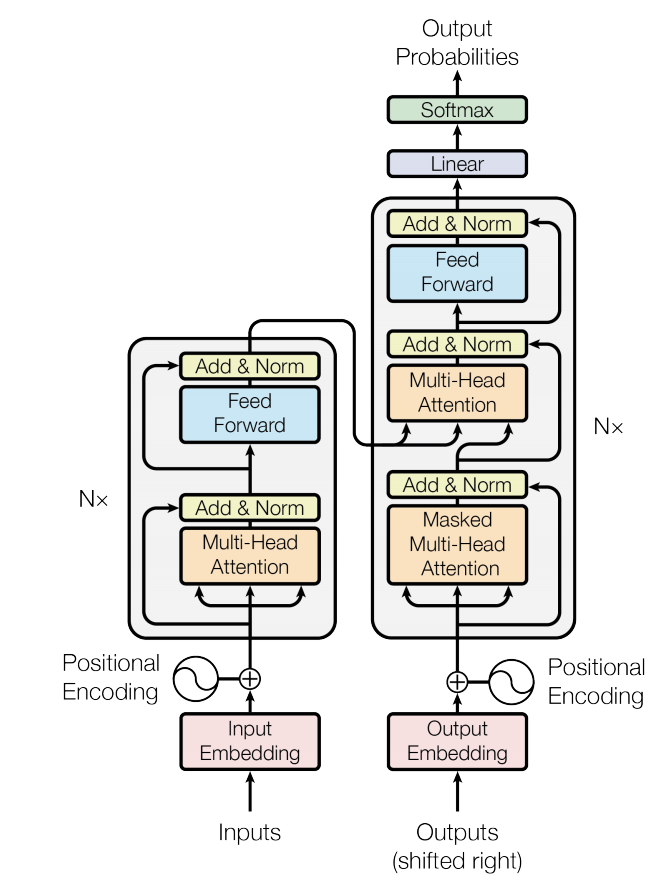

<a name='2-1'></a>
### 2.1 - Instantiate a new transformer model

We have packaged the code implemented in the previous week into the `Transformer.py` file. You can import it here, and setup with the same configuration used there. 

In [18]:
# Define the model parameters
num_layers = 2
embedding_dim = 128
fully_connected_dim = 128
num_heads = 2
positional_encoding_length = 256

encoder_vocab_size = int(tokenizer.vocab_size())
decoder_vocab_size = encoder_vocab_size

# Initialize the model
transformer = transformer_utils.Transformer(
    num_layers, 
    embedding_dim, 
    num_heads, 
    fully_connected_dim,
    encoder_vocab_size, 
    decoder_vocab_size, 
    positional_encoding_length, 
    positional_encoding_length,
)

Now, you will define the optimizer and the loss function. For this task the model will try to predict the masked words, so, as in the previous lab, the loss function will be the `SparseCategoricalCrossEntropy`.

In [19]:
learning_rate = transformer_utils.CustomSchedule(embedding_dim)
optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
train_loss = tf.keras.metrics.Mean(name='train_loss')

# Here you will store the losses, so you can later plot them
losses = []

<a name='2-2'></a>
### 2.2 - C4 pretraining

For training a Tensorflow model you need to arrange the data into datasets. Now, you will get the `inputs` and the `targets` for the transformer model from the `inputs_targets_pairs`. Before creating the dataset, you need to be sure that all `inputs` have the same length by truncating the longer sequences and padding the shorter ones with `0`. The same must be done for the targets. The function `tf.keras.preprocessing.sequence.pad_sequences` will help you here, as in the previous week assignment.

You will use a `BATCH_SIZE = 64`

In [20]:
# Limit the size of the input and output data so this can run in this environment
encoder_maxlen = 150
decoder_maxlen = 50

inputs = tf.keras.preprocessing.sequence.pad_sequences([x[0] for x in inputs_targets_pairs], maxlen=encoder_maxlen, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences([x[1] for x in inputs_targets_pairs], maxlen=decoder_maxlen, padding='post', truncating='post')

inputs = tf.cast(inputs, dtype=tf.int32)
targets = tf.cast(targets, dtype=tf.int32)

# Create the final training dataset.
BUFFER_SIZE = 10000
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Now, you can run the training loop for 10 epochs. Running it with a big dataset such as C4 on a good computer with enough memory and a good GPU could take more than 24 hours. Here, you will run few epochs using a small portion of the C4 dataset for illustration. It will only take a few minutes, but the model won't be very powerful. 

In [21]:
# Define the number of epochs
epochs = 10

# Training loop
for epoch in range(epochs):
    
    start = time.time()
    train_loss.reset_states()
    number_of_batches=len(list(enumerate(dataset)))

    for (batch, (inp, tar)) in enumerate(dataset):
        print(f'Epoch {epoch+1}, Batch {batch+1}/{number_of_batches}', end='\r')
        transformer_utils.train_step(inp, tar, transformer, loss_object, optimizer, train_loss)
    
    print (f'Epoch {epoch+1}, Loss {train_loss.result():.4f}')
    losses.append(train_loss.result())
    
    print (f'Time taken for one epoch: {time.time() - start} sec')

# Save the pretrained model
# transformer.save_weights('./model_c4_temp')

Epoch 1, Loss 10.1804
Time taken for one epoch: 26.78497076034546 sec
Epoch 2, Loss 9.6731
Time taken for one epoch: 9.862274169921875 sec
Epoch 3, Loss 9.2015
Time taken for one epoch: 9.85384202003479 sec
Epoch 4, Loss 8.7880
Time taken for one epoch: 8.390182971954346 sec
Epoch 5, Loss 8.4348
Time taken for one epoch: 7.200643539428711 sec
Epoch 6, Loss 8.1279
Time taken for one epoch: 6.813048839569092 sec
Epoch 7, Loss 7.8665
Time taken for one epoch: 6.530917167663574 sec
Epoch 8, Loss 7.6506
Time taken for one epoch: 7.157158613204956 sec
Epoch 9, Loss 7.4738
Time taken for one epoch: 6.122347593307495 sec
Epoch 10, Loss 7.3377
Time taken for one epoch: 4.618710994720459 sec


**Load a pretrained model**

To show how powerful this model actually is, we trained it for several epochs with the full dataset in Colab and saved the weights for you. You can load them using the cell below. For the rest of the notebook, you will see the power of the transfer learning in action.

In [22]:
transformer.load_weights('./pretrained_models/model_c4')

<a name='3'></a>
## 3. Fine tune the T5 model for Question Answering

Now,  you are going to fine tune the pretrained model for Question Answering using the [SQUad 2.0 dataset](https://rajpurkar.github.io/SQuAD-explorer/).

SQuAD, short for Stanford Question Answering Dataset, is a dataset designed for training and evaluating question answering systems. It consists of real questions posed by humans on a set of Wikipedia articles, where the answer to each question is a specific span of text within the corresponding article.

SQuAD 1.1, the previous version of the SQuAD dataset, contains 100,000+ question-answer pairs on about 500 articles.
SQuAD 2.0, contains 50.000 additional questions that are not meant to be answered. This extra set of questions can help to train models to detect unanswerable questions.

Let's load the dataset.

In [23]:
with open('data/train-v2.0.json', 'r') as f:
    example_jsons = json.load(f)

example_jsons = example_jsons['data']

print('Number of articles: ' + str(len(example_jsons)))

Number of articles: 442


The structure of each article is as follows:
- `title`: The article title
- `paragraphs`: A list of paragraphs and questions related to them
    - `context`: The actual paragraph text
    - `qas`: A set of question related to the paragraph
        - `question`: A question
        - `id`: The question unique identifier
        - `is_imposible`: Boolean, specifies if the question can be answered or not
        - `answers`: A set of possible answers for the question
            - `text`: The answer
            - `answer_start`: The index of the character that starts the sentence containing the explicit answer to the question
            
Take a look at an article by running the next cell. Notice that the `context` is usually the last element for every paragraph:           

In [24]:
example_article = example_jsons[0]
example_article

print("Title: " + example_article["title"])
print(example_article["paragraphs"][0])

Title: Beyoncé
{'qas': [{'question': 'When did Beyonce start becoming popular?', 'id': '56be85543aeaaa14008c9063', 'answers': [{'text': 'in the late 1990s', 'answer_start': 269}], 'is_impossible': False}, {'question': 'What areas did Beyonce compete in when she was growing up?', 'id': '56be85543aeaaa14008c9065', 'answers': [{'text': 'singing and dancing', 'answer_start': 207}], 'is_impossible': False}, {'question': "When did Beyonce leave Destiny's Child and become a solo singer?", 'id': '56be85543aeaaa14008c9066', 'answers': [{'text': '2003', 'answer_start': 526}], 'is_impossible': False}, {'question': 'In what city and state did Beyonce  grow up? ', 'id': '56bf6b0f3aeaaa14008c9601', 'answers': [{'text': 'Houston, Texas', 'answer_start': 166}], 'is_impossible': False}, {'question': 'In which decade did Beyonce become famous?', 'id': '56bf6b0f3aeaaa14008c9602', 'answers': [{'text': 'late 1990s', 'answer_start': 276}], 'is_impossible': False}, {'question': 'In what R&B group was she the

The previous article might be difficult to navigate so here is a nicely formatted example paragraph:
```python
{
  "context": "Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles 'Crazy in Love' and 'Baby Boy'",
  "qas": [
    {
      "question": "When did Beyonce start becoming popular?",
      "id": "56be85543aeaaa14008c9063",
      "answers": [
        {
          "text": "in the late 1990s",
          "answer_start": 269
        }
      ],
      "is_impossible": false
    },
    {
      "question": "What areas did Beyonce compete in when she was growing up?",
      "id": "56be85543aeaaa14008c9065",
      "answers": [
        {
          "text": "singing and dancing",
          "answer_start": 207
        }
      ],
      "is_impossible": false
    }
  ]
}
```

<a name='3-1'></a>
### 3.1 - Creating a list of paired question and answers 

You are tasked with generating input/output pairs for a Question Answering (QA) model using the SQuAD 2.0 dataset. Each pair follows the structure:

- inputs: `question: <Q> context: <P>`
- targets: `answer: <A>`
    
Here, `<Q>` represents the question in the context of the given paragraph `<P>`, and `<A>` is a possible answer.

In this notebook, we will focus on a single answer per question. However, it's essential to note that the dataset contains questions with multiple answers. When training a model in real-life scenarios, consider including all available information.

<a name='ex-2'></a>
### Exercise 2 - Parse the SQuaD 2.0 Dataset

Your task is to implement the parse_squad function, which iterates over all the articles, paragraphs, and questions in the SQuAD dataset. Extract pairs of inputs and targets for the QA model using the provided code template.
- Start with two empty lists: `inputs` and `targets`.
- Loop over all the articles in the dataset.
- For each article, loop over each paragraph.
- Extract the context from the paragraph.
- Loop over each question in the given paragraph.
- Check if the question is not impossible and has at least one answer.
- If the above condition is met, create the `question_context` sequence as described in the input structure.
- Create the `answer` sequence using the first answer from the available answers.
- Append the `question_context` to the `inputs` list.
- Append the `answer` to the `targets` list.

In [25]:
# GRADED FUNCTION: parse_squad
def parse_squad(dataset):
    """Extract all the answers/questions pairs from the SQuAD dataset

    Args:
        dataset (dict): The imported JSON dataset

    Returns:
        inputs, targets: Two lists containing the inputs and the targets for the QA model
    """

    inputs, targets = [], []

    ### START CODE HERE ###
    
    # Loop over all the articles
    for article in dataset:
        
        # Loop over each paragraph of each article
        for paragraph in article['paragraphs']:
            
            # Extract context from the paragraph
            context = paragraph['context']
            
            #Loop over each question of the given paragraph
            for qa in paragraph['qas']:
                
                # If this question is not impossible and there is at least one answer
                if len(qa['answers']) > 0 and not(qa['is_impossible']):
                    
                    # Create the question/context sequence
                    question_context = 'question: ' + qa['question'] + ' context: ' + context
                    
                    # Create the answer sequence. Use the text field of the first answer
                    answer = 'answer: ' + qa['answers'][0]['text']
                    
                    # Add the question_context to the inputs list
                    inputs.append(question_context)
                    
                    # Add the answer to the targets list
                    targets.append(answer)
    
    ### END CODE HERE ###
    
    return inputs, targets

In [26]:
inputs, targets =  parse_squad(example_jsons)          
print("Number of question/answer pairs: " + str(len(inputs)))

print('\nFirst Q/A pair:\n\ninputs: ' + colored(inputs[0], 'blue'))
print('\ntargets: ' + colored(targets[0], 'green'))
print('\nLast Q/A pair:\n\ninputs: ' + colored(inputs[-1], 'blue'))
print('\ntargets: ' + colored(targets[-1], 'green'))

Number of question/answer pairs: 86821

First Q/A pair:

inputs: question: When did Beyonce start becoming popular? context: Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".

targets: answer: in the late 1990s

Last Q/A pair:

inputs: question: What is KMC an initialism of? context: Kathmandu Metropolitan City (KMC), in order to promote international r

#### **Expected Output:**
```
Number of question/answer pairs: 86821

First Q/A pair:

inputs: question: When did Beyonce start becoming popular? context: Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".

targets: answer: in the late 1990s

Last Q/A pair:

inputs: question: What is KMC an initialism of? context: Kathmandu Metropolitan City (KMC), in order to promote international relations has established an International Relations Secretariat (IRC). KMC's first international relationship was established in 1975 with the city of Eugene, Oregon, United States. This activity has been further enhanced by establishing formal relationships with 8 other cities: Motsumoto City of Japan, Rochester of the USA, Yangon (formerly Rangoon) of Myanmar, Xi'an of the People's Republic of China, Minsk of Belarus, and Pyongyang of the Democratic Republic of Korea. KMC's constant endeavor is to enhance its interaction with SAARC countries, other International agencies and many other major cities of the world to achieve better urban management and developmental programs for Kathmandu.

targets: answer: Kathmandu Metropolitan City
```

In [27]:
# UNIT TEST
w3_unittest.test_parse_squad(parse_squad)

 All tests passed


You will use 50000 samples for training and 5000 samples for testing

In [28]:
# 50K pairs for training
inputs_train = inputs[0:40000] 
targets_train = targets[0:40000]  

# 5K pairs for testing
inputs_test = inputs[40000:45000] 
targets_test =  targets[40000:45000] 

Now, you can create the batch dataset of padded sequences. You will first tokenize the inputs and the targets. Then, using the function `tf.keras.preprocessing.sequence.pad_sequences`, you will ensure that the inputs and the outputs have the required lengths. Remember that the sequences longer than the required size will be truncated and the shorter ones will be padded with `0`. This setup is very similar to the other one used in this and the previous notebook.

In [29]:
# Limit the size of the input and output data so this can run in this environment
encoder_maxlen = 150
decoder_maxlen = 50

inputs_str = [tokenizer.tokenize(s) for s in inputs_train]
targets_str = [tf.concat([tokenizer.tokenize(s), [1]], 0) for s in targets_train]

inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs_str, maxlen=encoder_maxlen, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets_str, maxlen=decoder_maxlen, padding='post', truncating='post')

inputs = tf.cast(inputs, dtype=tf.int32)
targets = tf.cast(targets, dtype=tf.int32)

# Create the final training dataset.
BUFFER_SIZE = 10000
BATCH_SIZE = 64
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

<a name='3-2'></a>
### 3.2 Fine tune the T5 model

Now, you will train the model for 2 epochs. In the T5 model, all the weights are adjusted during the fine tuning. As usual, fine tuning this model to get state of the art results would require more time and resources than there are available in this environment, but you are welcome to train the model for more epochs and with more data using Colab GPUs.

In [30]:
# Define the number of epochs
epochs = 2
losses = []

# Training loop
for epoch in range(epochs):
    
    start = time.time()
    train_loss.reset_states()
    number_of_batches=len(list(enumerate(dataset)))

    for (batch, (inp, tar)) in enumerate(dataset):
        print(f'Epoch {epoch+1}, Batch {batch+1}/{number_of_batches}', end='\r')
        transformer_utils.train_step(inp, tar, transformer, loss_object, optimizer, train_loss)
    
    print (f'Epoch {epoch+1}, Loss {train_loss.result():.4f}')
    losses.append(train_loss.result())
    
    print (f'Time taken for one epoch: {time.time() - start} sec')
    #if epoch % 15 == 0:
        #transformer.save_weights('./pretrained_models/model_qa_temp')
# Save the final model
#transformer.save_weights('./pretrained_models/model_qa_temp')

Epoch 1, Loss 5.979325
Time taken for one epoch: 76.7011091709137 sec
Epoch 2, Loss 5.352625
Time taken for one epoch: 36.13371920585632 sec


To get a model that works properly, you would need to train for about 100 epochs. So, we have pretrained a model for you. Just load the weights in the current model and let's use it for answering questions

In [31]:
# Restore the weights
transformer.load_weights('./pretrained_models/model_qa3')

<a name='3-3'></a>
### 3.3 - Implement your Question Answering model
In this final step, you will implement the answer_question function, utilizing a pre-trained transformer model for question answering.

To help you out the `transformer_utils.next_word` function is provided. This function receives the question and beginning of the answer (both in tensor format) alongside the model to predict the next token in the answer. The next cell shows how to use this:

In [32]:
# Define an example question
example_question = "question: What color is the sky? context: Sky is blue"

# Question is tokenized and padded
# Note that this is hardcoded here but you must implement this in the upcoming exercise
tokenized_padded_question = tf.constant([[822, 10, 363, 945, 19, 8, 5796, 58, 2625, 10, 5643, 19, 1692, 0, 0]])

# All answers begin with the string "answer: "
# Feel free to check that this is indeed the tokenized version of that string
tokenized_answer = tf.constant([[1525,   10]])

# Predict the next word using the transformer_utils.next_word function
# Notice that it expects the question, answer and model (in that order)
next_word = transformer_utils.next_word(tokenized_padded_question, tokenized_answer, transformer)

print(f"Predicted next word is: '{tokenizer.detokenize(next_word).numpy()[0].decode('utf-8')}'")

# Concatenate predicted word with answer so far
answer_so_far = tf.concat([tokenized_answer, next_word], axis=-1)

print(f"Answer so far: '{tokenizer.detokenize(answer_so_far).numpy()[0].decode('utf-8')}'")

Predicted next word is: 'blue'
Answer so far: 'answer: blue'


<a name='ex-3'></a>
### Exercise 3 - Implement the question answering function

Implement the `answer_question` function. Here are the steps:
- **Question Setup:**

  - Tokenize the given question using the provided tokenizer.
  - Add an extra dimension to the tensor for compatibility.
  - Pad the question tensor using `pad_sequences` to ensure the sequence has the specified max length. This function will truncate the sequence if it is larger or pad with zeros if it is shorter.
- **Answer Setup:**
  - Tokenize the initial answer, noting that all answers begin with the string "answer: ".
  - Add an extra dimension to the tensor for compatibility.
  - Get the id of the `EOS` token, typically represented by 1.
- **Generate Answer:**
  - Loop for `decoder_maxlen` iterations.
  - Use the `transformer_utils.next_word` function, which predicts the next token in the answer using the model, input document, and the current state of the output.
  - Concatenate the predicted next word to the output tensor.
- **Stop Condition:**
  - The text generation stops if the model predicts the `EOS` token.
  - If the `EOS` token is predicted, break out of the loop.

In [78]:
# GRADED FUNCTION: answer_question
def answer_question(question, model, tokenizer, encoder_maxlen=150, decoder_maxlen=50):
    """
    A function for question answering using the transformer model
    Arguments:
        question (tf.Tensor): Input data with question and context
        model (tf.keras.model): The transformer model
        tokenizer (function): The SentencePiece tokenizer
        encoder_maxlen (number): Max length of the encoded sequence
        decoder_maxlen (number): Max length of the decoded sequence
    Returns:
        _ (str): The answer to the question
    """
    
    ### START CODE HERE ###
    
    # QUESTION SETUP
    
    # Tokenize the question
    tokenized_question = tokenizer.tokenize(question)
    
    # Add an extra dimension to the tensor
    tokenized_question = tf.expand_dims(tokenized_question, 0) 
    
    # Pad the question tensor
    padded_question = tf.keras.preprocessing.sequence.pad_sequences(tokenized_question,
                                                                    maxlen=encoder_maxlen,
                                                                    padding='post', 
                                                                    truncating='post') 
    # ANSWER SETUP
    
    # Tokenize the answer
    # Hint: All answers begin with the string "answer: "
    tokenized_answer = tokenizer.tokenize("answer: ")
    
    # Add an extra dimension to the tensor
    tokenized_answer = tf.expand_dims(tokenized_answer, 0)
    
    # Get the id of the EOS token
    eos = tokenizer.string_to_id("</s>") 
    
    # Loop for decoder_maxlen iterations
    for i in range(decoder_maxlen):
        
        # Predict the next word using the model, the input document and the current state of output
        next_word = transformer_utils.next_word(padded_question, tokenized_answer, model)
        
        # Concat the predicted next word to the output 
        tokenized_answer = tf.concat([tokenized_answer, next_word], axis=1)
        
        # The text generation stops if the model predicts the EOS token
        if tf.math.argmax(next_word, axis=-1).numpy() == eos:
            break
    
    ### END CODE HERE ###

    return tokenized_answer

Let's test the model with some question from the training dataset. Check if the answers match the correct one.

In [79]:
idx = 10408

result = answer_question(inputs_train[idx], transformer, tokenizer)
print(colored(pretty_decode(result, sentinels, tokenizer).numpy()[0], 'blue'))
print()
print(inputs_train[idx])
print(colored(targets_train[idx], 'green'))

b'answer: January 9, 1957//, (forc General Canneiious'

question: When was the Chechen-Ingush Autonomous Soviet Socialist Republic transferred from the Georgian SSR? context: On January 9, 1957, Karachay Autonomous Oblast and Chechen-Ingush Autonomous Soviet Socialist Republic were restored by Khrushchev and they were transferred from the Georgian SSR back to the Russian SFSR.
answer: January 9, 1957


#### **Expected Output:**
```
b'answer: January 9, 1957'

question: When was the Chechen-Ingush Autonomous Soviet Socialist Republic transferred from the Georgian SSR? context: On January 9, 1957, Karachay Autonomous Oblast and Chechen-Ingush Autonomous Soviet Socialist Republic were restored by Khrushchev and they were transferred from the Georgian SSR back to the Russian SFSR.
answer: January 9, 1957
```

In [80]:
# UNIT TEST
w3_unittest.test_answer_question(answer_question)

 All tests passed


Test the model with question 110

In [81]:
idx = 110
result = answer_question(inputs_test[idx], transformer, tokenizer)
print(colored(pretty_decode(result, sentinels, tokenizer).numpy()[0], 'blue'))
print()
print(inputs_test[idx])
print(colored(targets_test[idx], 'green'))

b'answer: 50'

question:  What percentage of the vote was recorded as approving Napoleon's constitution? context: Napoleon established a political system that historian Martyn Lyons called "dictatorship by plebiscite." Worried by the democratic forces unleashed by the Revolution, but unwilling to ignore them entirely, Napoleon resorted to regular electoral consultations with the French people on his road to imperial power. He drafted the Constitution of the Year VIII and secured his own election as First Consul, taking up residence at the Tuileries. The constitution was approved in a rigged plebiscite held the following January, with 99.94 percent officially listed as voting "yes." Napoleon's brother, Lucien, had falsified the returns to show that 3 million people had participated in the plebiscite; the real number was 1.5 million. Political observers at the time assumed the eligible French voting public numbered about 5 million people, so the regime artificially doubled the participat

Test the model with question 301. Use this cell to play with the model by selecting other test questions. Look if the model has learnt something or if it is just generating random text.

In [82]:
idx = 311
result = answer_question(inputs_test[idx], transformer, tokenizer)
print(colored(pretty_decode(result, sentinels, tokenizer).numpy()[0], 'blue'))
print()
print(inputs_test[idx])
print(colored(targets_test[idx], 'green'))

b'answer: June 1840'

question:  On what date was a state funeral held for Napoleon? context: In 1840, Louis Philippe I obtained permission from the British to return Napoleon's remains to France. On 15 December 1840, a state funeral was held. The hearse proceeded from the Arc de Triomphe down the Champs-Élysées, across the Place de la Concorde to the Esplanade des Invalides and then to the cupola in St Jérôme's Chapel, where it remained until the tomb designed by Louis Visconti was completed. In 1861, Napoleon's remains were entombed in a porphyry sarcophagus in the crypt under the dome at Les Invalides.
answer: 15 December 1840


Congratulations, you have finished the last assignment of this specialization. Now, you know what is behind the powerful models like ChatGPT. Now it is time for you to find and solve the huge amount of problems that can be approached with NLP.